In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd   /content/drive/MyDrive/prueba_tenica_BC/
!pwd

/content/drive/MyDrive/prueba_tenica_BC
/content/drive/MyDrive/prueba_tenica_BC


In [3]:
!ls

bert_ds  dataset  EDA.ipynb  model_train  train_model.ipynb  train_tf_smallBert.ipynb


In [4]:
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install -U "tensorflow-text==2.13.*" -q
!pip install "tf-models-official==2.13.*" -q

### Se importan las librerías necesarias como el HUB de tensorflow, el optimizador entre otras utilidades también para la carga de los datos

In [6]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

### cargando los datasets desde las carpetas que contienen el texto en un txt de cada observación y su respectiva clasificación

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [28]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './dataset/bert_un_sp/train',
    batch_size=batch_size,
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7723 files belonging to 2 classes.


In [29]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './dataset/bert_un_sp/val',
    batch_size=batch_size,
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1309 files belonging to 2 classes.


In [30]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    './dataset/bert_un_sp/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2741 files belonging to 2 classes.


In [31]:
raw_train_ds.class_names

['False', 'True']

### Balanceo de clases

Como se indicó en el problema a resolver (diplomacy game) las clases entre verdadera y falsa se debe hacer un proceso de blanceo y se procederá con un un weight class para darle mayor fuerza a la clase no dominante al momento de calcular la función de pérdida, con el fin de que al momento del entrenamiento tengamos una forma de identificar con mayor facilidad esa clase que no se da con tanta frecuencia

In [32]:
# Pesar las clases
neg_size = 553
ps_size = 7167

weight_for_0 = (1 / neg_size) * ( (neg_size + ps_size)/ 2.0)
weight_for_1 = (1 / ps_size) * ((neg_size + ps_size)/ 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 6.980108499095841, 1: 0.5385796009487931}

validemos algunos textos con el label correcto

In [33]:
for text_batch, label_batch in test_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'maybe misunderstanding'
Label: 1
Question:  b'thats fair im personally proleave sweden russia wanted doublecheck'
Label: 1
Question:  b'think thats fair lets go'
Label: 1
Question:  b'hello turkey believe could benefit coordination relates east open level dialogue issue'
Label: 1
Question:  b'turkey ser tri f alb ser tri f bla con rum ser bul rum ser apu ven ion nap russia bud alb tri gal vie h vie h nwy h nwg nwy h war pru ukr mos england edi nth garuntees us tri prevents france getting centers think basically best possible thing could situation please dont give give till end'
Label: 1
Question:  b'id rather fight east rn looks like need every single center get ill keep denmark'
Label: 1
Question:  b'rather took denmark next turn'
Label: 1
Question:  b'support u somewhere else u'
Label: 0
Question:  b'already'
Label: 1
Question:  b'true bud back rum ser alb could position forward convoys without needing rear fleet'
Label: 0


Al igual que en el siguiente tutorial nos guiaremos del hub de tensorflow para elegir el modelo que a priori sea mas eficiente tanto a nivel computacional como por las métricas generadas.

tomado de: https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=es-419


Se elige un small BERT uncased menos numero de párámetros para un entrenamiento más veloz que en uno normal

SMall BERT

In [48]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess  =  'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

Experts/BERT

In [38]:
tfhub_handle_encoder = 'https://www.kaggle.com/models/google/experts-bert/TensorFlow2/pubmed/2'
tfhub_handle_preprocess  =  'https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3'

Se definirá la arquitectura del modelo customizado, recordemos que lo anterior es el modelo base o preinicializado que se elige y apartir de esos pesos iniciaremos con un fine tunning

In [49]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Capa de entrada
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # Capa Preprocesamiento
  encoder_inputs = preprocessing_layer(text_input) # Capa encoder
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # Capas del modelo preentrenado
  outputs = encoder(encoder_inputs) # Encoder final
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net) # Drop out para evitar sobreajuste
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net) # Capa final de seleccion de clases
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

Se agenera la función de pérdida binaria pues recordemos que solo tenemos dos clases

la métrica será generada por un accuracy binario

In [50]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

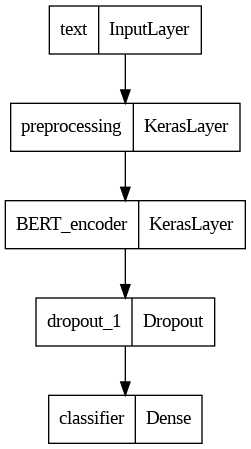

In [51]:
tf.keras.utils.plot_model(classifier_model)

### Optimizador

acá es donde se define el optimizador para el modelen este caso un AdamW, los steps por Epoch, el learning rate y los steps warmup

In [52]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Compilación del modelo con el optimizador, la funciópn de perdida y las métricas

In [53]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Se setea elstop early o parada temprana para que dejen de actualizarsen los pesos cuando la métrica establecida se mantenga o decrezac y el save_best para que guarde el modelo cuando la métrica tenga un mejor desempeño

In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_binary_accuracy',
    patience = 4,
    restore_best_weights=True)

save_best = tf.keras.callbacks.ModelCheckpoint(
    './model_train/best_model_samllBert.weights.h5 ',
    monitor="val_binary_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

Se inicia el entrenamiento y uno de ls parámetros insignia es el class_weight que recordemos es un diccionario que contienen los pesos para cada clase y esto ayuda el balanceo de clases, recompensa a prporción cuando se predice correctamente

In [55]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight =class_weight,
                               callbacks = [stop_early, save_best])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/15
242/242 [==============================] - 42s 161ms/step - loss: 0.6775 - binary_accuracy: 0.5008 - val_loss: 0.6376 - val_binary_accuracy: 0.6241
Epoch 2/15
242/242 [==============================] - 38s 157ms/step - loss: 0.5429 - binary_accuracy: 0.7713 - val_loss: 0.8549 - val_binary_accuracy: 0.7074
Epoch 3/15
242/242 [==============================] - 34s 139ms/step - loss: 0.5321 - binary_accuracy: 0.8475 - val_loss: 1.0600 - val_binary_accuracy: 0.6921
Epoch 4/15
242/242 [==============================] - 33s 138ms/step - loss: 0.5373 - binary_accuracy: 0.8699 - val_loss: 1.0435 - val_binary_accuracy: 0.7013
Epoch 5/15
242/242 [==============================] - 33s 138ms/step - loss: 0.5150 - binary_accuracy: 0.8672 - val_loss: 1.1184 - val_binary_accuracy: 0.6967
Epoch 6/15
242/242 [==============================] - 33s 137ms/step - loss: 0.5149 - binary_accuracy: 0.8827 - v

Se procede luego a la validación del modelo con el conjunto de test

In [56]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

86/86 [==============================] - 3s 38ms/step - loss: 0.8824 - binary_accuracy: 0.6892
Loss: 0.8824289441108704
Accuracy: 0.6891645193099976


In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score

In [58]:
y_true = np.concatenate([y.numpy() for _, y in test_ds])
ypredict1 = classifier_model.predict(test_ds)
y_pred = (ypredict1 > 0.5).astype(int)

86/86 [==============================] - 3s 38ms/step


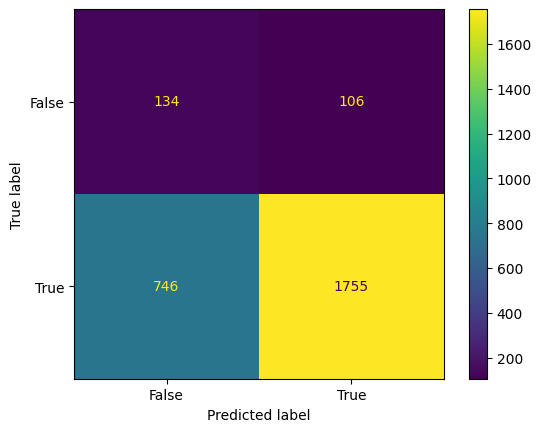

In [59]:
con = confusion_matrix(y_true, y_pred )
ConfusionMatrixDisplay(con, display_labels=["False", 'True']).plot()

In [60]:
f1_score_evaluation = f1_score(y_true, y_pred,average=None)
f1_score_macro = f1_score(y_true, y_pred,average='macro')

print('--'*40)
print("F1 score por clase = {}".format(f1_score_evaluation))
print('--'*40)
print("F1 Score Macro = {}".format(f1_score_macro))
print('--'*40)

--------------------------------------------------------------------------------
F1 score por clase = [0.23928571 0.80467675]
--------------------------------------------------------------------------------
F1 Score Macro = 0.5219812340341914
--------------------------------------------------------------------------------
